In [8]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

path = os.getcwd()
if path.split('/')[-1] == 'notebooks':
    os.chdir('..')
%matplotlib inline

In [9]:
from src.engine import Engine
from src.utils.util import *
from src.core.criterions import *

# Load a model

In [10]:
config_path = 'configs/mln_resnet18_cub.yml'
save_dir = '/home/yo0n/바탕화면/RIL/ucam/notebook_test'
logger = load_log(save_dir)
checkpoint_path = '/home/yo0n/바탕화면/RIL/ucam/ckpt_cub/checkpoint_best.pth'

In [11]:
engine = Engine(config_path, logger, save_dir,device='cuda')
engine.model_config['checkpoint_path'] = checkpoint_path
engine.define()


[2021-08-06 23:07:22,090 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] GPU is available.


Build a dataloader
Build a model


[2021-08-06 23:07:22,646 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] SGD opimizer is built.
[2021-08-06 23:07:22,647 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] CUSTOM scheduler is built.
[2021-08-06 23:07:22,649 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Criterion is built.
[2021-08-06 23:07:22,649 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loss meter is built.
[2021-08-06 23:07:22,650 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Checkpointer is built.
[2021-08-06 23:07:22,650 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loading checkpoint from /home/yo0n/바탕화면/RIL/ucam/ckpt_cub/checkpoint_best.pth
[2021-08-06 23:07:22,746 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Localizer is built.
[2021-08-06 23:07:22,746 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Evaluators are built.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

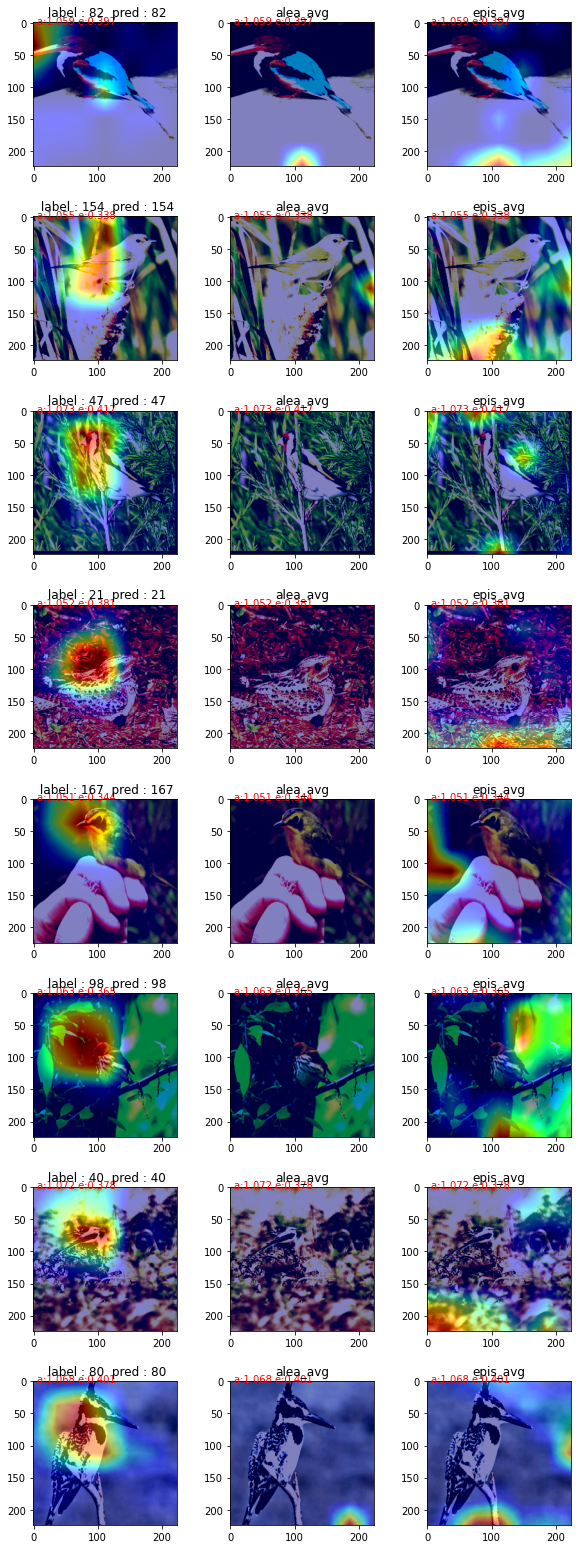

In [12]:
import random 

loss_types = ['mace_avg','alea_avg','epis_avg']

img,label,gt_boxes = iter(engine.dataloaders['train']).next()
bs = img.shape[0]
with torch.no_grad():
    output_dict = engine.model(img.cuda())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel']
ind_sel = torch.topk(mu_sel,3,dim=-1)[-1]

#print(mu_sel[1], label[1])

plt.figure(figsize=(10,80))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
l = [i for i in range(bs)]
random.shuffle(l)

for j,ind in enumerate(l[:8]):
    for i,loss_type in enumerate(loss_types):
        
        engine.model.eval()
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type
        
        pred_label = torch.tensor([ind_sel[ind,0]]).long()
        
        if loss_types=='mace_avg':
            cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), label[ind])
        else:
            cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), pred_label.to('cuda'))
        cams = cams.cpu().detach().squeeze().numpy()
        #print(cams)
        
        epis = unct_out['epis'][j]
        alea = unct_out['alea'][j]
        
        plt.subplot(8*3,3,3*j+i+1)
        if(i==0):
            plt.title(" label : " + str(label[ind].numpy()) + "  pred : " + str(ind_sel[ind,0].cpu().numpy()))
        else:
            plt.title(loss_type)
        plt.imshow(img[ind].permute(1,2,0) + 0.5)
        plt.imshow(cams, alpha=0.5, cmap='jet')
        plt.text(5, 2, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10, color='red')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1440x11520 with 0 Axes>

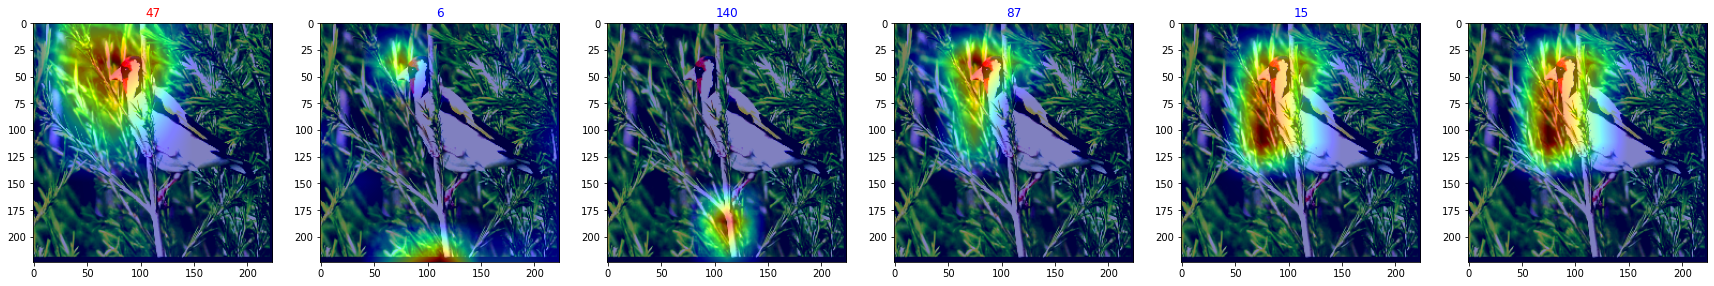

In [17]:
plt.figure(figsize=(20,160))

randInd = random.randint(0,32)

largest_pi_ind = torch.argmax(pi[randInd])
mixture_k = engine.model.mol.fc_pi.weight.size(0)
mixture_cams = list()

plt.figure(figsize=(30,100))
for k in range(mixture_k):
    engine.localizer.register_hooks()
    engine.localizer.model_ext.loss_type= 'mace_avg'
    mixture_pred_name = str(torch.argmax(mu[randInd,k]).cpu().numpy())
    
    cams = engine.localizer.localize(img[randInd].unsqueeze(0).to('cuda').float(), label[randInd].to('cuda'), mixture=k)
    cams = cams.cpu().detach().squeeze().numpy()
    
    plt.subplot(mixture_k,mixture_k+1,k+1)
    if(largest_pi_ind==k):
        plt.title(mixture_pred_name,color='red')
    else:
        plt.title(mixture_pred_name,color='blue')
    plt.imshow(img[randInd].permute(1,2,0) + 0.5)
    plt.imshow(cams, alpha=0.5, cmap='jet')
    mixture_cams.append(cams)

engine.localizer.remove_hooks()

engine.localizer.register_hooks()
cams = engine.localizer.localize(img[randInd].unsqueeze(0).to('cuda').float(), label[randInd].to('cuda'), mixture=k)
engine.localizer.remove_hooks()

plt.subplot(mixture_k, mixture_k+1, k+2)
plt.imshow(img[randInd].detach().permute(1,2,0).cpu() + 0.5)
plt.imshow(cams.detach().cpu().squeeze(), alpha=0.5, cmap='jet')

## Mean and Variance of CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


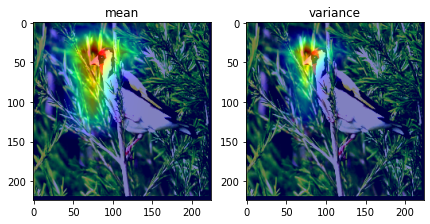

In [18]:
kcams = np.array(mixture_cams) # [K x W x H]

plt.figure(figsize=(7,14))

plt.subplot(2,2,1)
plt.title("mean")
plt.imshow(img[randInd].detach().permute(1,2,0).cpu() + 0.5)
plt.imshow(np.mean(kcams, axis=0), alpha=0.5, cmap='jet')

plt.subplot(2,2,2)
plt.title("variance")
plt.imshow(img[randInd].detach().permute(1,2,0).cpu() + 0.5)
plt.imshow(np.var(kcams, axis=0), alpha=0.5, cmap='jet')

## Eval

In [19]:
for i, (images, labels, gt_boxes) in enumerate(engine.dataloaders['val']):
    print(gt_boxes)

tensor([[ 14,   4, 180, 223],
        [  0,  66, 189, 203],
        [  0,  12, 128, 223],
        [ 11,   0, 214, 223],
        [ 12,   3, 121, 223],
        [ 14,   0, 177, 223],
        [ 11,  13, 201, 147],
        [ 56,  46, 186, 196],
        [ 13,  11, 198, 163],
        [ 53,  43, 208, 173],
        [  0,   0, 223, 223],
        [ 37,  18, 202, 207],
        [ 72,  60, 207, 212],
        [  2,  25, 211, 147],
        [ 17,  22, 174, 223],
        [  0,   0, 223, 203],
        [ 33,   0, 153, 181],
        [ 36,  23, 202, 223],
        [ 17,  50, 201, 174],
        [  6,   0, 212, 223],
        [ 39,  49, 197, 210],
        [ 47,  23, 122, 223],
        [ 13,  18, 211, 162],
        [  0, 102, 223, 223],
        [ 67, 117, 160, 183],
        [  0,  95, 217, 194],
        [103,  12, 181, 219],
        [ 51,   8, 159, 215],
        [ 93,  50, 197, 187],
        [ 20,   6, 135, 206],
        [ 57,  11, 223, 123],
        [ 20,  30, 216, 183],
        [  8,   1, 207, 186],
        [ 

tensor([[  4,  51, 164, 201],
        [ 77,  17, 204, 194],
        [ 90,  62, 223, 210],
        [ 56,  24, 196, 213],
        [ 13,  54,  80, 174],
        [  0,   0, 223, 223],
        [ 70,  39, 153, 158],
        [  0,  24, 183, 216],
        [ 45,  80, 153, 192],
        [ 83,   0, 135, 222],
        [ 20,   6, 195, 204],
        [ 66,  10, 169, 221],
        [ 55,  27, 136, 190],
        [ 52,  63, 138, 201],
        [ 23,  87, 116, 194],
        [ 90,  60, 151, 138],
        [100,  20, 212, 113],
        [ 49,  56, 133, 186],
        [ 77,  58, 223, 180],
        [115,  27, 183, 195],
        [ 68,  79, 136, 164],
        [ 52,  52, 175, 184],
        [ 49,  22, 112, 187],
        [  0,  42, 152, 208],
        [ 93,  34, 149, 209],
        [ 13,  31, 123, 223],
        [ 49,  57, 176, 162],
        [ 44,  50, 122, 209],
        [ 42,  60, 181, 148],
        [ 28,  71, 132, 169],
        [ 39,  11, 196, 219],
        [ 58,  43, 149, 167],
        [ 10,  26, 166, 205],
        [ 

KeyboardInterrupt: 

## Ambiguous MNIST

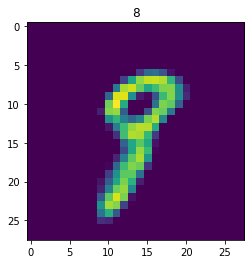

In [12]:
from src.core.datasets import AmbiguousMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

transform  = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (1.0,))
                    ])
amnist_validset = AmbiguousMNIST(root = "./data", train=False)
amnist_valid_loader = DataLoader(amnist_validset, batch_size=128,shuffle=True, num_workers=0)

rndInd = random.randint(0,len(amnist_validset))
plt.title(str(amnist_validset[rndInd][1].numpy()))
plt.imshow(amnist_validset[rndInd][0][0])

In [13]:
alea_mnist = list()
epis_mnist = list()
mnist_labels = list()
mnist_pi_ind = list()
mnist_pred = list()
mnist_correct = list()
alea_amnist = list()
epis_amnist = list()
amnist_correct = list()

for img,target,_ in engine.dataloaders['test']:
    bs = img.shape[0]
    with torch.no_grad():
        output_dict = engine.model(img.cuda())
    pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
    unct_out = mln_uncertainties(pi, mu, sigma)
    sel_out = mln_gather(output_dict)
    mu_sel = sel_out['mu_sel']
    mnist_correct += list((torch.argmax(mu_sel,dim=1).cpu()==target.cpu()).cpu().numpy())
    alea_mnist += list(unct_out['alea'].cpu().numpy())
    epis_mnist += list(unct_out['epis'].cpu().numpy())
    mnist_pi_ind += list(torch.argmax(pi,dim=1).cpu().numpy())
    mnist_labels += list(target.cpu().numpy())
    mnist_pred += list(torch.argmax(mu_sel,dim=1).cpu().numpy())
    
for img,target,_ in amnist_valid_loader:
    bs = img.shape[0]
    with torch.no_grad():
        output_dict = engine.model(img.cuda())
    pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
    unct_out = mln_uncertainties(pi, mu, sigma)
    sel_out = mln_gather(output_dict)
    mu_sel = sel_out['mu_sel']
    amnist_correct += list((torch.argmax(mu_sel,dim=1).cpu()==target.cpu()).cpu().numpy())
    alea_amnist += list(unct_out['alea'].cpu().numpy())
    epis_amnist += list(unct_out['epis'].cpu().numpy())

In [23]:
import seaborn as sns

confusion_matrix = np.zeros((10,5))
for i in range(len(mnist_labels)):
    confusion_matrix[mnist_pred[i],mnist_pi_ind[i]] += 1
    
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

NameError: name 'mnist_labels' is not defined

<AxesSubplot:>

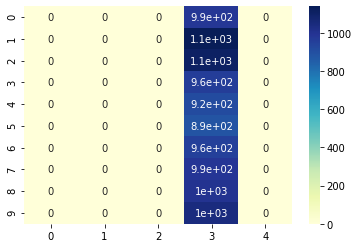

In [14]:
import seaborn as sns

confusion_matrix = np.zeros((10,5))
for i in range(len(mnist_labels)):
    confusion_matrix[mnist_pred[i],mnist_pi_ind[i]] += 1
    
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

(array([1.03201560e+02, 1.27102093e+01, 7.50477926e+00, 3.14501766e+00,
        1.58337828e+00, 1.10617863e+00, 1.30140681e-01, 4.33795539e-02,
        3.25351702e-01, 0.00000000e+00, 8.67591079e-02, 0.00000000e+00,
        2.16897770e-02, 0.00000000e+00, 6.50693309e-02, 8.67604538e-02,
        0.00000000e+00, 0.00000000e+00, 1.08448885e-01, 2.16901135e-02]),
 array([1.0000501, 1.0077341, 1.0154182, 1.0231022, 1.0307863, 1.0384703,
        1.0461544, 1.0538384, 1.0615225, 1.0692065, 1.0768905, 1.0845746,
        1.0922586, 1.0999427, 1.1076267, 1.1153108, 1.1229948, 1.1306789,
        1.1383629, 1.146047 , 1.153731 ], dtype=float32),
 <BarContainer object of 20 artists>)

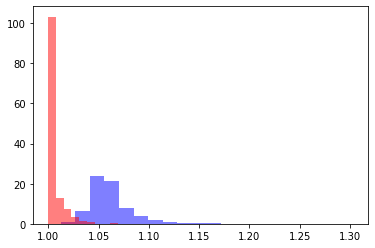

In [26]:
plt.hist(alea_mnist,color='blue',alpha=0.5, bins=20, density=True)
plt.hist(alea_amnist,color='red',alpha=0.5, bins=20, density=True)

(array([ 350.,  850.,  980., 1580., 2170., 3230., 5100., 7070., 7830.,
        7750., 6680., 5040., 3420., 2910., 1810., 1490., 1030.,  480.,
         170.,   60.]),
 array([0.01071721, 0.04330348, 0.07588976, 0.10847604, 0.14106232,
        0.1736486 , 0.20623487, 0.23882115, 0.27140743, 0.3039937 ,
        0.33657998, 0.36916625, 0.40175253, 0.4343388 , 0.46692508,
        0.49951136, 0.53209764, 0.5646839 , 0.5972702 , 0.62985647,
        0.66244274], dtype=float32),
 <BarContainer object of 20 artists>)

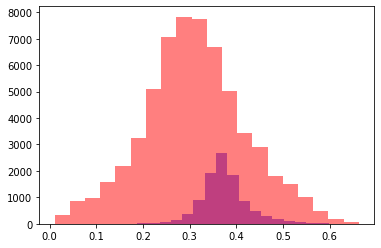

In [27]:
plt.hist(epis_mnist,color='blue',alpha=0.5, bins=20)
plt.hist(epis_amnist,color='red',alpha=0.5, bins=20)

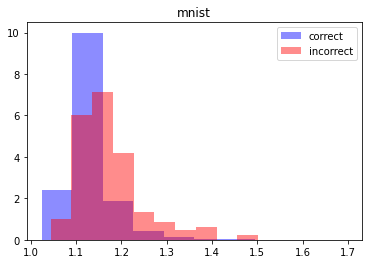

In [28]:
plt.title("mnist")
plt.hist(np.power(np.array(alea_mnist)[np.array(mnist_correct)==1],2),color='blue', alpha=0.45, density=True, label='correct')
plt.hist(np.power(np.array(alea_mnist)[np.array(mnist_correct)==0],2),color='red', alpha=0.45, density=True, label='incorrect')
plt.legend()

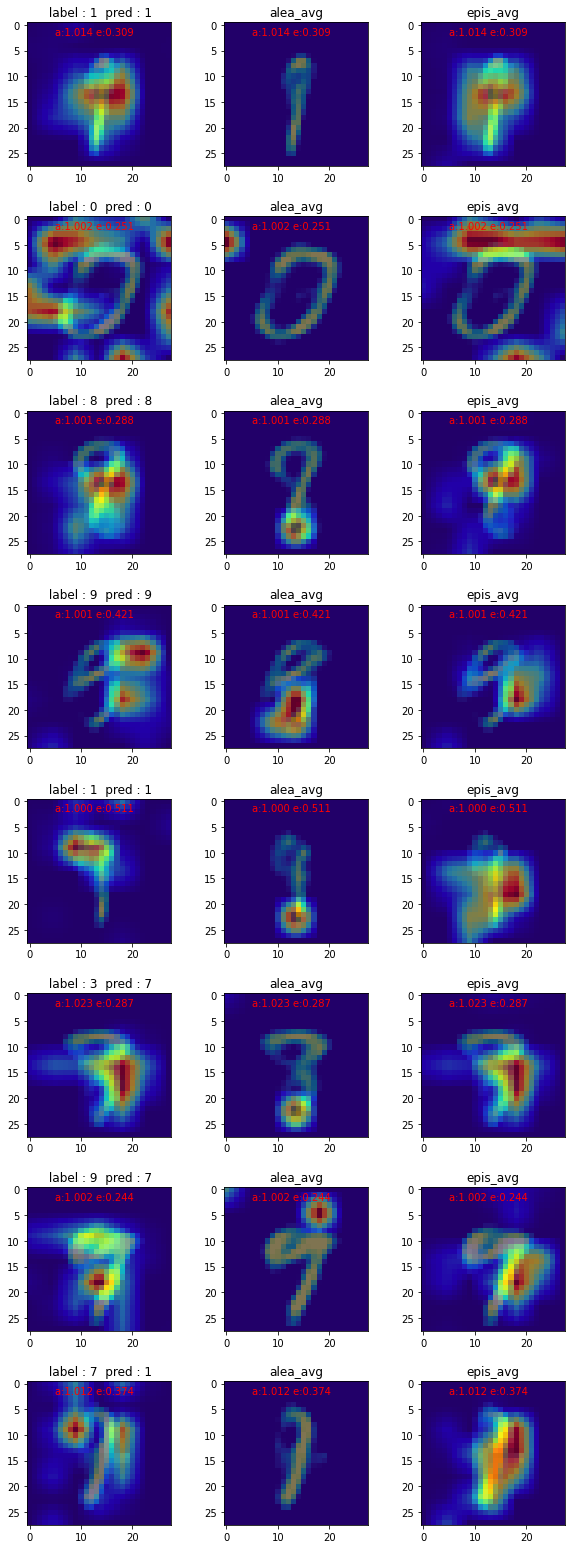

In [29]:
import random 

loss_types = ['mace_avg','alea_avg','epis_avg']

img,label,_ = iter(amnist_valid_loader).next()
bs = img.shape[0]
with torch.no_grad():
    output_dict = engine.model(img.cuda())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel']
ind_sel = torch.topk(mu_sel,3,dim=-1)[-1]

#print(mu_sel[1], label[1])

plt.figure(figsize=(10,80))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
l = [i for i in range(bs)]
random.shuffle(l)

for j,ind in enumerate(l[:8]):
    for i,loss_type in enumerate(loss_types):
        
        engine.model.eval()
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type
        
        pred_label = torch.tensor([ind_sel[ind,0]]).long()
        
        cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), pred_label.to('cuda'))
        cams = cams.cpu().detach().squeeze().numpy()
        #print(cams)
        
        epis = unct_out['epis'][j]
        alea = unct_out['alea'][j]
        
        plt.subplot(8*3,3,3*j+i+1)
        if(i==0):
            plt.title(" label : " + str(label[ind].numpy()) + "  pred : " + str(ind_sel[ind,0].cpu().numpy()))
        else:
            plt.title(loss_type)
        plt.imshow(img[ind].squeeze() + 0.5)
        plt.imshow(cams, alpha=0.5, cmap='jet')
        plt.text(5, 2, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10, color='red')

# OOD (SVHN)

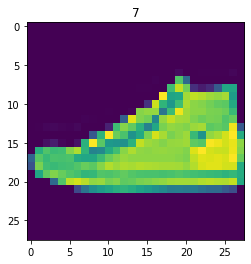

In [30]:
import torchvision

fmnist_valid = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
fmnist_valid_loader = DataLoader(fmnist_valid, batch_size=128,shuffle=True, num_workers=0)

rndInd = random.randint(0,len(fmnist_valid))
plt.title(str(fmnist_valid[rndInd][1]))
plt.imshow(fmnist_valid[rndInd][0].squeeze() + 0.5)

In [31]:

alea_fmnist = list()
epis_fmnist = list()
fmnist_correct = list()


for img,target in fmnist_valid_loader:
    bs = img.shape[0]
    with torch.no_grad():
        output_dict = engine.model(img.cuda())
    pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
    unct_out = mln_uncertainties(pi, mu, sigma)
    sel_out = mln_gather(output_dict)
    mu_sel = sel_out['mu_sel']
    fmnist_correct += list((torch.argmax(mu_sel,dim=1).cpu()==target.cpu()).cpu().numpy())
    alea_fmnist += list(unct_out['alea'].cpu().numpy())
    epis_fmnist += list(unct_out['epis'].cpu().numpy())

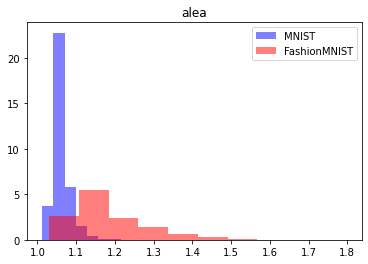

In [32]:
plt.title("alea")
plt.hist(alea_mnist,color='blue',alpha=0.5, density=True, label='MNIST')
plt.hist(alea_fmnist,color='red',alpha=0.5, density=True, label='FashionMNIST')
plt.legend()

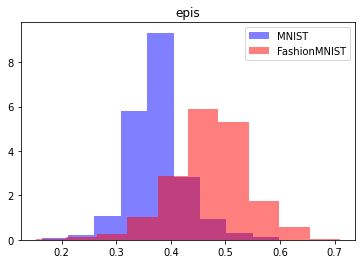

In [33]:
plt.title("epis")
plt.hist(epis_mnist,color='blue',alpha=0.5, density=True, label='MNIST')
plt.hist(epis_fmnist,color='red',alpha=0.5, density=True, label='FashionMNIST')
plt.legend()

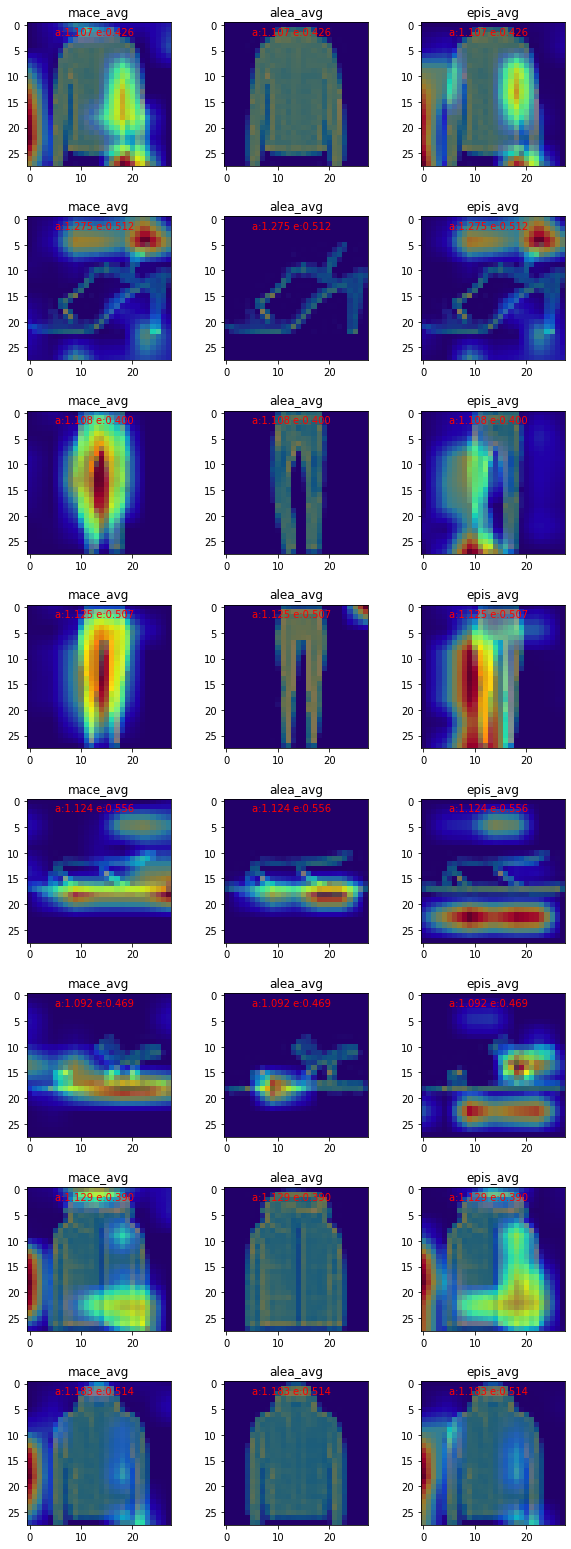

In [35]:
import random 

loss_types = ['mace_avg','alea_avg','epis_avg']

img,label = iter(fmnist_valid_loader).next()
bs = img.shape[0]
with torch.no_grad():
    output_dict = engine.model(img.cuda())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel']
ind_sel = torch.topk(mu_sel,3,dim=-1)[-1]

#print(mu_sel[1], label[1])

plt.figure(figsize=(10,80))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
l = [i for i in range(bs)]
random.shuffle(l)

for j,ind in enumerate(l[:8]):
    for i,loss_type in enumerate(loss_types):
        
        engine.model.eval()
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type
        
        pred_label = torch.tensor([ind_sel[ind,0]]).long()
        
        cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), pred_label.to('cuda'))
        cams = cams.cpu().detach().squeeze().numpy()
        #print(cams)
        
        epis = unct_out['epis'][j]
        alea = unct_out['alea'][j]
        
        plt.subplot(8*3,3,3*j+i+1)
        plt.title(loss_type)
        plt.imshow(img[ind].squeeze() + 0.5)
        plt.imshow(cams, alpha=0.5, cmap='jet')
        plt.text(5, 2, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10, color='red')